<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import Anndata objects for two biological replicates, SRR26046013 (cells treated with AOA inhibitor) and SRR26046019 (untreated cells)
Perform following steps:
(1) Import matrices
(2) Compute fragment size distribution
(3) Compute TSS enrichment
(4) Filter cell counts based on TSSe
(5) Create cell by bin matrix based on 500 bp wide bins accross the whole genome
(6) Perform feature selection
(7) Perform Doublet removal
(8) Perform Dim reduction (spectral)
(9) Perform Clustering (neighborhood, UMAP, leiden)
(10) Create a cell by gene matrix
(11) Concatenate matrices using Inner join
(12) Remove batch effects

In [1]:
!pip install -q condacolab

In [2]:
import condacolab

In [3]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda --version

conda 23.11.0


In [5]:
!which conda

/usr/local/bin/conda


In [6]:
!conda config --add channels conda-forge

In [7]:
!conda config --add channels bioconda

In [8]:
!conda install snapatac2 -q

Channels:
 - bioconda
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



In [9]:
!pip show snapatac2

Name: snapatac2
Version: 2.7.1
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [10]:
import snapatac2 as snap

In [11]:
!pip install umap-learn



In [12]:
import umap.umap_ as umap


In [13]:
from umap import UMAP

In [14]:
!pip install scanpy -q

In [15]:
import scanpy as sc

In [16]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [87]:
!pip install magic-impute -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
snapatac2 2.7.1 requires numpy<2.0.0,>=1.16.0, but you have numpy 2.0.2 which is incompatible.


In [98]:
!pip install leidenalg -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00


In [17]:
import numpy as np

In [18]:
import anndata as ad

In [19]:
import matplotlib.pyplot as plt

In [20]:
import plotly.subplots as sp
import plotly.graph_objects as go

Import reads from google drive, one sample treated with energy metabolism inhibitors and one untreated

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
SRR26046013_DM_AOA_INH = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/SRR26046013_Annotated_data_matrix.h5ad')

In [23]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 13546 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [24]:
SRR26046019_DM_UT = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/SRR26046019_Annotated_data_matrix.h5ad')

In [25]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 10448 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

Compute fragment size distributions

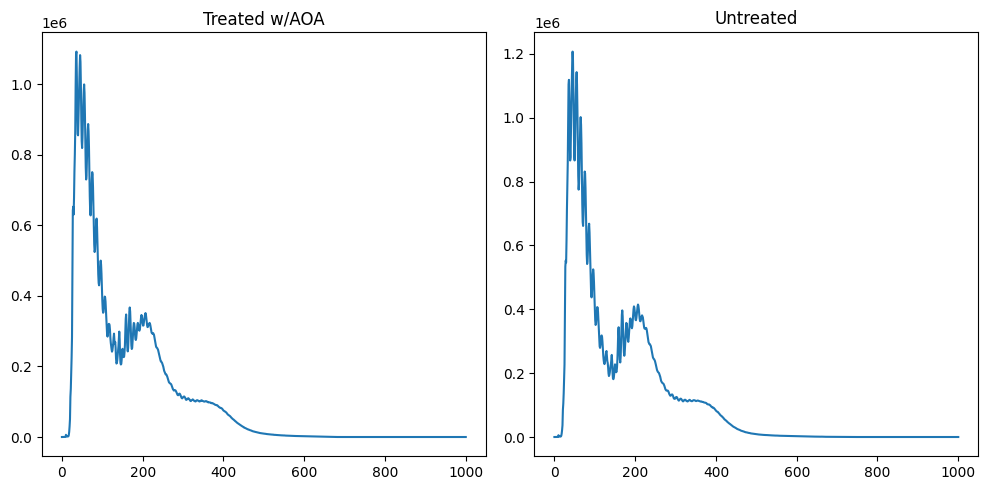

In [26]:
# Create a subplot figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot for SRR26046013_DM_AOA_INH
frag_size_distr = snap.metrics.frag_size_distr(SRR26046013_DM_AOA_INH, inplace=False)
axes[0].plot(frag_size_distr)
axes[0].set_title('Treated w/AOA')

# Plot for SRR26046019_DM_UT
frag_size_distr4 = snap.metrics.frag_size_distr(SRR26046019_DM_UT, inplace=False)
axes[1].plot(frag_size_distr4)
axes[1].set_title('Untreated')

plt.tight_layout()
plt.show()

Compute and plot TSSe

In [27]:
# Compute TSSe metrics
# Get genome annotation
gene_anno = snap.genome.hg38

In [28]:
snap.metrics.tsse(SRR26046013_DM_AOA_INH, gene_anno)

In [29]:
snap.metrics.tsse(SRR26046019_DM_UT, gene_anno)

In [30]:
# Generate TSSE plots
TSSE1plot = snap.pl.tsse(SRR26046013_DM_AOA_INH, show = False)
TSSE2plot = snap.pl.tsse(SRR26046019_DM_UT,show = False)

# Create a subplot figure
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Treated w/AOA', 'Untreated'))

# Add the plots to the subplot figure
fig.add_trace(TSSE1plot.data[0], row=1, col=1)
fig.add_trace(TSSE2plot.data[0], row=1, col=2)

# Update layout and set X-axis to logarithmic scale
fig.update_layout(height=400, width=800, title_text="TSS enrichment")
fig.update_xaxes(type="log", row=1, col=1)
fig.update_xaxes(type="log", row=1, col=2)

fig.show()
fig.write_image("TSSE_plots.png", height=1080, width=1920)

/usr/local/lib/python3.10/site-packages/snapatac2/plotting/__init__.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = adata.obs["n_fragment"][selected_cells]
/usr/local/lib/python3.10/site-packages/snapatac2/plotting/__init__.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = adata.obs["tsse"][selected_cells]
/usr/local/lib/python3.10/site-packages/snapatac2/plotting/__init__.py:97: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

In [31]:
gene_anno

fig.write_image("TSSe_plot.png",  width=1920, height=1080)

#Filter cell counts and TSSE values based on above plots

In [32]:
snap.pp.filter_cells(SRR26046013_DM_AOA_INH, min_counts=3000, min_tsse=15, max_counts=70000)

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



In [33]:
snap.pp.filter_cells(SRR26046019_DM_UT, min_counts=6000, min_tsse=13, max_counts=90000)

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



In [34]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6612 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

In [35]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5771 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

#Write to file
SRR26046013_DM_AOA_INH.write_h5ad('SRR26046013_DM_AOA_INH_filt.h5ad')
SRR26046019_DM_UT.write_h5ad('SRR26046018_DM_UT_filt.h5ad')

Create cell by bin matrix containing insertion counts across genome-wide 500-bp bins

In [36]:
snap.pp.add_tile_matrix(SRR26046013_DM_AOA_INH)

In [37]:
snap.pp.add_tile_matrix(SRR26046019_DM_UT)

In [38]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6612 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

In [39]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5771 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

Perform feature selection

In [40]:
snap.pp.select_features(SRR26046013_DM_AOA_INH, n_features = 250000)

2025-01-01 11:45:36 - INFO - Selected 250000 features.


In [41]:
snap.pp.select_features(SRR26046019_DM_UT, n_features = 250000)

2025-01-01 11:45:39 - INFO - Selected 250000 features.


In [42]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6612 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

In [43]:
#sc.write(adata=SRR26046013_DM_AOA_INH,filename="SRR26046013_Annotated_data_matrix_P1.h5ad",compression='gzip')

Doublet removal

In [44]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6612 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile'
    obsm: 'fragment_paired'

In [45]:
#Apply a scrublet algorithm to identify potential doublets
snap.pp.scrublet(SRR26046013_DM_AOA_INH)

2025-01-01 11:45:42 - INFO - Simulating doublets...
2025-01-01 11:45:45 - INFO - Spectral embedding ...
/usr/local/lib/python3.10/site-packages/snapatac2/preprocessing/_scrublet.py:258: FutureWarning:

X.dtype being converted to np.float32 from uint32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

2025-01-01 11:49:04 - INFO - Calculating doublet scores...


In [46]:
snap.pp.scrublet(SRR26046019_DM_UT)

2025-01-01 11:49:13 - INFO - Simulating doublets...
2025-01-01 11:49:15 - INFO - Spectral embedding ...
/usr/local/lib/python3.10/site-packages/snapatac2/preprocessing/_scrublet.py:258: FutureWarning:

X.dtype being converted to np.float32 from uint32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

2025-01-01 11:53:54 - INFO - Calculating doublet scores...


In [47]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6612 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

In [48]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5771 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score'
    obsm: 'fragment_paired'

In [49]:
#Filter doublets
snap.pp.filter_doublets(SRR26046013_DM_AOA_INH)

2025-01-01 11:54:01 - INFO - Detected doublet rate = 5.535%
/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



In [50]:
snap.pp.filter_doublets(SRR26046019_DM_UT)

2025-01-01 11:54:07 - INFO - Detected doublet rate = 5.978%


In [51]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6246 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

In [52]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5426 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

Dimension reduction

In [53]:
snap.tl.spectral(SRR26046013_DM_AOA_INH)

In [54]:
snap.tl.spectral(SRR26046019_DM_UT)

In [55]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6246 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral'

In [56]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5426 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral'

In [57]:
snap.tl.umap(SRR26046013_DM_AOA_INH)

/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [58]:
snap.tl.umap(SRR26046019_DM_UT)

/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [59]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6246 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'

In [60]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5426 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'

Clustering analysis

In [61]:
#(1)Calculate knn graph, (2) use Leiden community detection, (3) plot UMAP (returns plotly object)

In [62]:
snap.pp.knn(SRR26046013_DM_AOA_INH)
snap.tl.leiden(SRR26046013_DM_AOA_INH)
SRR26046013_DM_AOA_INH_UMAP = snap.pl.umap(SRR26046013_DM_AOA_INH, color = 'leiden', interactive = False, show = False)

In [63]:
snap.pp.knn(SRR26046019_DM_UT)
snap.tl.leiden(SRR26046019_DM_UT)
SRR26046019_DM_UT_UMAP = snap.pl.umap(SRR26046019_DM_UT, color='leiden', interactive=False, show=False)

In [64]:
# Create a subplot figure
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Treated w/AOA', 'Untreated'))

# Add all traces from each UMAP plot to the subplot figure
for trace in SRR26046013_DM_AOA_INH_UMAP.data:
 trace.showlegend = False  # Hide legend for individual traces
 fig.add_trace(trace, row=1, col=1)

for trace in SRR26046019_DM_UT_UMAP.data:
 fig.add_trace(trace, row=1, col=2)  # Show legend only for the last subplot

# Update layout with legend title and position
fig.update_layout(height=600, width=1200, title_text="UMAP Clustering", legend_title_text='Clusters', legend=dict(x=1.05, y=1, traceorder='normal', font=dict(family='sans-serif', size=12, color='black'), bordercolor='Black', borderwidth=1))

fig.show()
fig.write_image("Cluster_plots.png", height=1080, width=1920)

#Write structures to file
SRR26046013_DM_AOA_INH.write_h5ad("SRR26046013_PI.h5ad")

SRR26046019_DM_UT.write_h5ad("SRR26046019_PI.h5ad")

Create a cell-by-gene activity matrix

In [65]:
#sc.write(SRR26046013_DM_AOA_INH,"/SRR26046013_DM_AOA_INH.h5ad")

In [66]:
SRR26046019_DM_UT

AnnData object with n_obs × n_vars = 5426 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

In [67]:
SRR26046013_DM_AOA_INH_GM = snap.pp.make_gene_matrix(SRR26046013_DM_AOA_INH, snap.genome.hg38)

In [68]:
SRR26046019_DM_UT_GM = snap.pp.make_gene_matrix(SRR26046019_DM_UT, snap.genome.hg38)

In [69]:
SRR26046013_DM_AOA_INH_GM

AnnData object with n_obs × n_vars = 6246 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

In [70]:
SRR26046019_DM_UT_GM

AnnData object with n_obs × n_vars = 5426 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

In [71]:
SRR26046013_DM_AOA_INH

AnnData object with n_obs × n_vars = 6246 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'library_tsse', 'frac_overlap_TSS', 'TSS_profile', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

In [72]:
SRR26046013_DM_AOA_INH_GM

AnnData object with n_obs × n_vars = 6246 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

In [76]:
SRR26046019_DM_UT_GM

AnnData object with n_obs × n_vars = 5426 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

Imputation with scanpy and MAGIC

In [88]:
%%time
sc.pp.filter_genes(SRR26046013_DM_AOA_INH_GM, min_cells= 5)
sc.pp.normalize_total(SRR26046013_DM_AOA_INH_GM)
sc.pp.log1p(SRR26046013_DM_AOA_INH_GM)



CPU times: user 4.36 s, sys: 1.58 s, total: 5.93 s
Wall time: 3.06 s


In [89]:
sc.external.pp.magic(SRR26046013_DM_AOA_INH_GM, solver="approximate")

/usr/local/lib/python3.10/site-packages/magic/utils.py:145: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [90]:
# Copy over UMAP embedding
SRR26046013_DM_AOA_INH_GM.obsm["X_umap"] = SRR26046013_DM_AOA_INH.obsm["X_umap"]

In [91]:
sc.pp.filter_genes(SRR26046019_DM_UT_GM, min_cells= 5)
sc.pp.normalize_total(SRR26046019_DM_UT_GM)
sc.pp.log1p(SRR26046019_DM_UT_GM)

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



In [92]:
sc.external.pp.magic(SRR26046019_DM_UT_GM, solver="approximate")

/usr/local/lib/python3.10/site-packages/magic/utils.py:145: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [94]:
# Copy over UMAP embedding
SRR26046019_DM_UT_GM.obsm["X_umap"] = SRR26046019_DM_UT.obsm["X_umap"]

In [95]:
SRR26046013_DM_AOA_INH_GM

AnnData object with n_obs × n_vars = 6246 × 53726
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [96]:
SRR26046019_DM_UT_GM

AnnData object with n_obs × n_vars = 5426 × 56382
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

Preprocess according to scanpy flow

In [99]:
sc.pp.scale(SRR26046013_DM_AOA_INH_GM, max_value = 10)
sc.pp.pca(SRR26046013_DM_AOA_INH_GM, svd_solver = 'arpack')
sc.pp.neighbors(SRR26046013_DM_AOA_INH_GM, n_neighbors=10, n_pcs=40)
sc.tl.umap(SRR26046013_DM_AOA_INH_GM)
sc.tl.leiden(SRR26046013_DM_AOA_INH_GM)

<ipython-input-99-aec6c1cda992>:5: FutureWarning:

In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.



In [100]:
%%time
sc.pp.scale(SRR26046019_DM_UT_GM, max_value = 10)
sc.pp.pca(SRR26046019_DM_UT_GM, svd_solver = 'arpack')
sc.pp.neighbors(SRR26046019_DM_UT_GM, n_neighbors=10, n_pcs=40)
sc.tl.umap(SRR26046019_DM_UT_GM)

CPU times: user 1min 40s, sys: 30.8 s, total: 2min 11s
Wall time: 26.4 s


In [101]:
sc.tl.leiden(SRR26046019_DM_UT_GM)

In [102]:
SRR26046013_DM_AOA_INH_GM

AnnData object with n_obs × n_vars = 6246 × 53726
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [103]:
SRR26046019_DM_UT_GM

AnnData object with n_obs × n_vars = 5426 × 56382
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Identify marker genes

In [104]:
SRR26046013_DM_AOA_INH_GM_MG = sc.tl.rank_genes_groups(SRR26046013_DM_AOA_INH_GM, 'leiden', method='wilcoxon', copy = True)
SRR26046018_DM_UT_GM_MG = sc.tl.rank_genes_groups(SRR26046019_DM_UT_GM, 'leiden', method='wilcoxon', copy = True)

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:434: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

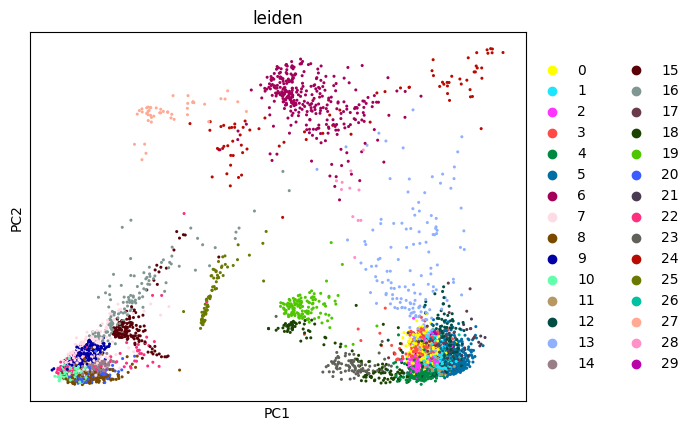

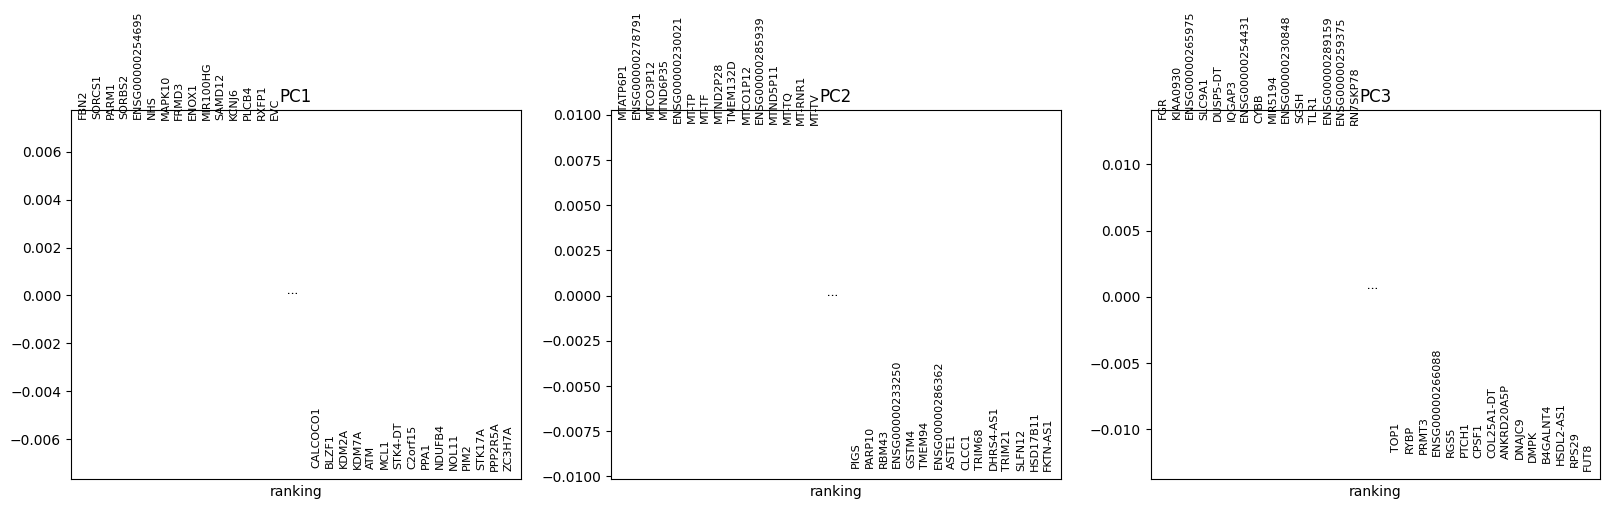

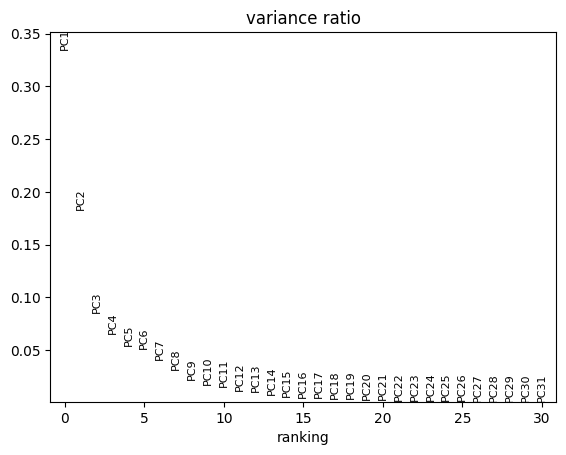

In [105]:
sc.pl.pca_overview(SRR26046013_DM_AOA_INH_GM, color ='leiden')

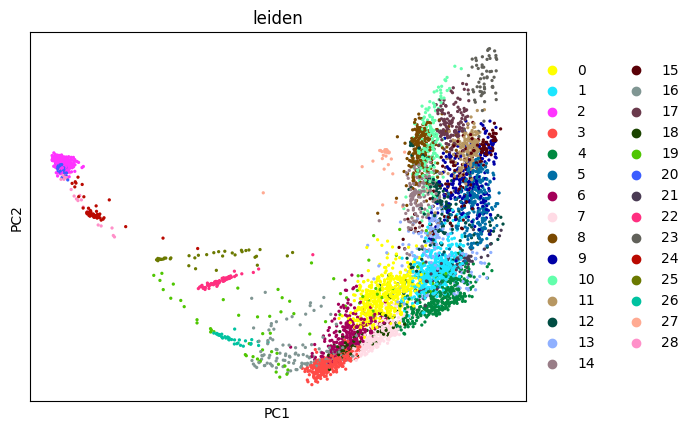

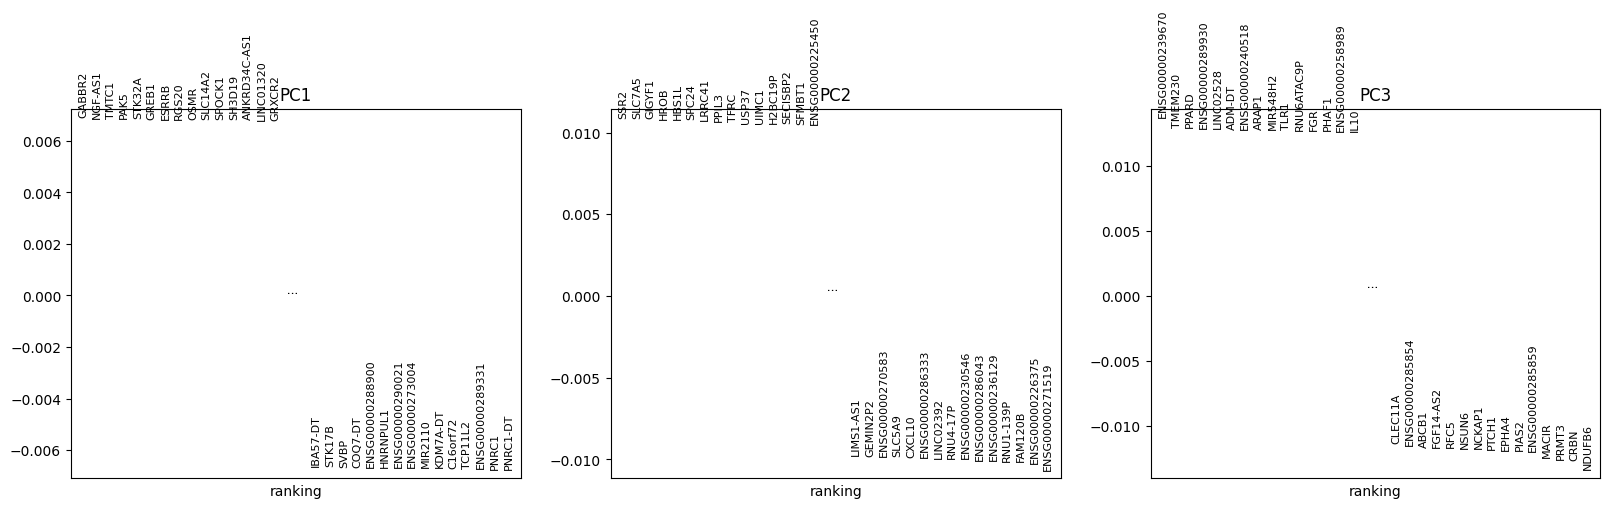

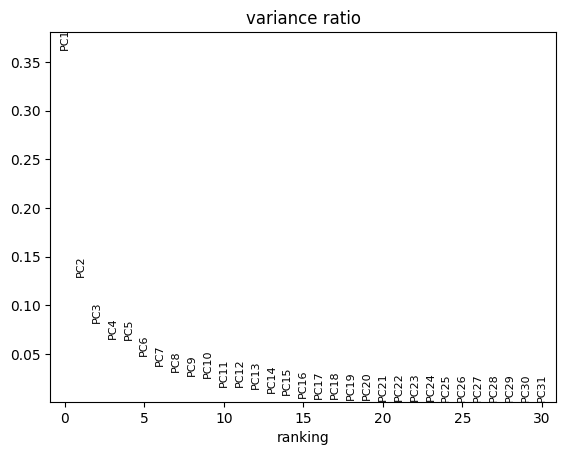

In [106]:
sc.pl.pca_overview(SRR26046019_DM_UT_GM, color ='leiden')

In [113]:
#Obtain ranked genes for all clustes
ranked_genes_dict = SRR26046013_DM_AOA_INH_GM_MG.uns['rank_genes_groups']

# Get all cluster IDs
cluster_ids = ranked_genes_dict['names'].dtype.names

# Iterate through each cluster and print the top 10 genes
for cluster_id in cluster_ids:
    # Get ranked genes for the current cluster
    cluster_genes = ranked_genes_dict['names'][cluster_id]

    # Print the top 10 genes for the current cluster
    print(f"Top 10 genes for cluster {cluster_id}:")
    print(cluster_genes[:10])
    print("\n")

Top 10 genes for cluster 0:
['ENSG00000286481' 'SLC24A3' 'RIPOR3' 'ABCC4' 'PBX1' 'MECOM' 'LIMCH1'
 'GATA2-AS1' 'SYN3' 'CLCN3P1']


Top 10 genes for cluster 1:
['RIPOR3' 'CTTNBP2' 'ENSG00000286481' 'NKAIN2' 'CALN1' 'ELOAP1'
 'LINC02284' 'NPR3' 'DDC' 'LINC01505']


Top 10 genes for cluster 2:
['RBPMS' 'MECOM' 'LINC01122' 'ENSG00000228401' 'FAR2' 'MEF2C' 'PRDM16'
 'ARHGAP22' 'NKAIN2' 'MEIS1']


Top 10 genes for cluster 3:
['ABCC4' 'STXBP6' 'PBX1' 'ASIC4' 'HPSE2' 'DNAJC6' 'SLC24A3' 'RNU6-299P'
 'ENSG00000289887' 'ENSG00000290081']


Top 10 genes for cluster 4:
['PRR5L' 'RET' 'SLCO2A1' 'MEF2C' 'ARHGAP22' 'BAALC' 'CALN1' 'LINC01341'
 'MEIS1' 'ENSG00000228430']


Top 10 genes for cluster 5:
['ATP8B4' 'MMP2' 'MRPS22' 'RASGRF1' 'RHEX' 'NTM' 'HCK' 'ENSG00000287899'
 'RFX8' 'CTTNBP2']


Top 10 genes for cluster 6:
['MT-TL2' 'MT-TS2' 'MT-TH' 'MT-ND5' 'MT-ND4' 'MT-TQ' 'MT-TC' 'MT-TM'
 'MT-TA' 'MT-TY']


Top 10 genes for cluster 7:
['BCL11B' 'CAMK4' 'TCF7' 'LEF1' 'SCML4' 'FYB1' 'SARDH' 'CD247' 'LINC

Concatenate Data matrices

In [114]:
#Use inner join
adata_concat = ad.concat([SRR26046013_DM_AOA_INH_GM, SRR26046019_DM_UT_GM], label = 'Treatment', keys = ['Treated w/AOA', 'Untreated'], join='inner')

/usr/local/lib/python3.10/site-packages/anndata/_core/merge.py:858: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



Remove batch effects

In [81]:
import scanpy.external as sce

In [83]:
pip install harmonypy -q

In [84]:
import harmonypy as hm

In [119]:
import seaborn as sns

In [115]:
sce.pp.harmony_integrate(adata_concat, 'Treatment')

2025-01-01 19:07:06,653 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-01 19:07:06 - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-01 19:07:12,287 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-01 19:07:12 - INFO - sklearn.KMeans initialization complete.
2025-01-01 19:07:12,388 - harmonypy - INFO - Iteration 1 of 10
2025-01-01 19:07:12 - INFO - Iteration 1 of 10
2025-01-01 19:07:18,333 - harmonypy - INFO - Iteration 2 of 10
2025-01-01 19:07:18 - INFO - Iteration 2 of 10
2025-01-01 19:07:24,598 - harmonypy - INFO - Iteration 3 of 10
2025-01-01 19:07:24 - INFO - Iteration 3 of 10
2025-01-01 19:07:30,613 - harmonypy - INFO - Iteration 4 of 10
2025-01-01 19:07:30 - INFO - Iteration 4 of 10
2025-01-01 19:07:37,197 - harmonypy - INFO - Iteration 5 of 10
2025-01-01 19:07:37 - INFO - Iteration 5 of 10
2025-01-01 19:07:43,132 - harmonypy - INFO - Iteration 6 of 10
2025-01-01 19:07:43 - INFO - Iteration 6 of 10
2025-01-01

In [116]:
adata_concat

AnnData object with n_obs × n_vars = 11672 × 53588
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment'
    obsm: 'X_umap', 'X_pca', 'X_pca_harmony'

Plot the 'obsm' before and after batch effect removal

In [117]:
#Extract data sets
x_before = adata_concat.obsm['X_pca'][:, 0]
y_before = adata_concat.obsm['X_pca'][:, 1]

x_after = adata_concat.obsm['X_pca_harmony'][:, 0]
y_after = adata_concat.obsm['X_pca_harmony'][:, 1]
batch_labels = adata_concat.obs['Treatment']


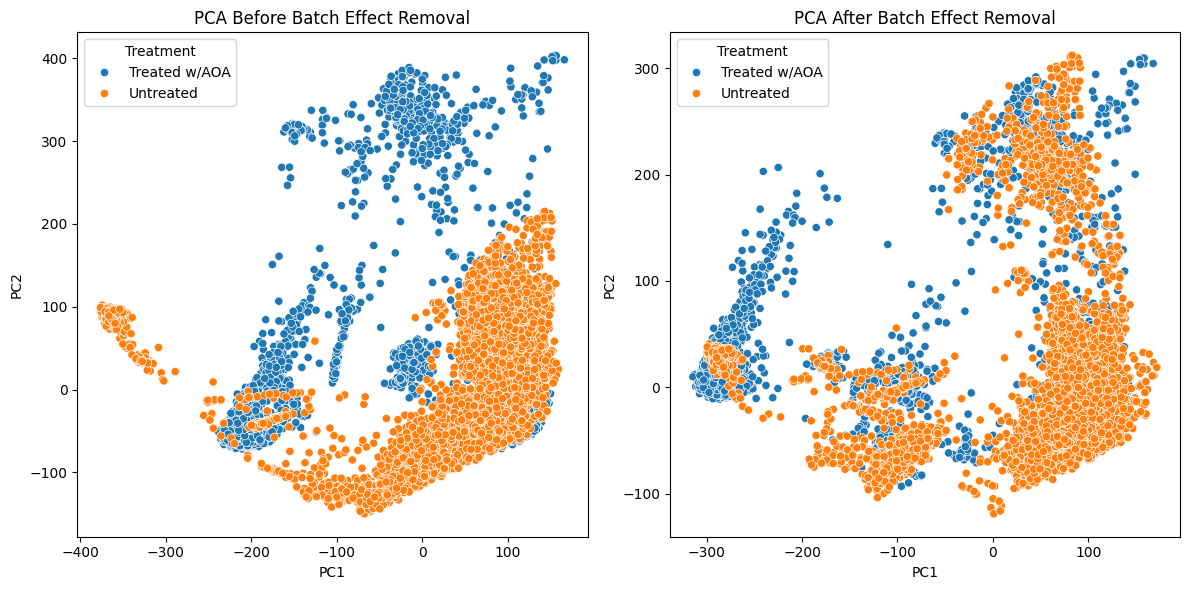

In [120]:
#Define figure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#Plot before batch effect removal

sns.scatterplot(x=x_before, y=y_before, hue=batch_labels)
plt.title('PCA Before Batch Effect Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')

#Plot PCA after batch effect removal

plt.subplot(1, 2, 2)
sns.scatterplot(x=x_after, y=y_after, hue=batch_labels)
plt.title('PCA After Batch Effect Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

Differential accesibility analysis

In [77]:
import numpy as np

In [78]:
from scipy import stats

In [79]:
# Assuming adata is your AnnData object
condition1 = adata_concat[adata_concat.obs['Treatment'] == 'Treated w/AOA']
condition2 = adata_concat[adata_concat.obs['Treatment'] == 'Untreated']

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



In [80]:
# Perform a t-test for each peak/gene
pvals = []
for peak in adata_concat.var_names:
 _, pval = stats.ttest_ind(condition1[:, peak].X.toarray(), condition2[:, peak].X.toarray())
 pvals.append(pval)

KeyboardInterrupt: 

In [ ]:
# Adjust p-values for multiple testing (e.g., using Benjamini-Hochberg)
from statsmodels.stats.multitest import multipletests
_, pvals_adj, _, _ = multipletests(pvals, method='fdr_bh')

In [ ]:
# Add p-values to AnnData object
adata.var['pvals'] = pvals
adata.var['pvals_adj'] = pvals_adj

In [ ]:
Filter Significant DARs: Filter the results to retain only those regions that are significantly differentially accessible after multiple testing correction.

In [ ]:
significant_dars = adata.var[adata.var['pvals_adj'] < 0.05]

In [ ]:
Visualize Results: Visualize the differentially accessible regions using various plotting functions available in scanpy or other visualization libraries.

In [ ]:
sc.pl.heatmap(adata, var_names=significant_dars.index, groupby='condition')

Interpret Results: Interpret the biological significance of the differentially accessible regions. This might involve looking at the genes associated with these regions and understanding their roles in the biological conditions you are studying.